https://ec.europa.eu/competition/mergers/cases/index/nace_all.html

# Import Necessary Packages

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

# 0. Define Custom Functions

In [2]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

# 1. Import data

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/MarcellM01/Data-Analysis-3/main/Assignment_3/cs_bisnode_panel.csv")

In [4]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [5]:
data.columns

Index(['comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod',
       'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories',
       'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind',
       'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

# 2. Data Handling

## 2.1 Label Engineering

In [7]:
# add all missing year and comp_id combinations
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

### 2.1.1 Create default flag

In [8]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [9]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [10]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [11]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

## 2.2 Feature Engineering

### 2.2.1 Dealing with Industry Codes

In [12]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [13]:
data.groupby("ind2_cat").count()["comp_id"]

ind2_cat
20.0       675
26.0     14877
27.0      9116
28.0     26098
29.0      4379
30.0      2499
32.0      1820
33.0     21839
35.0         6
40.0      2766
55.0     33756
56.0    165521
60.0      3439
99.0    270153
Name: comp_id, dtype: int64

In [14]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### 2.2.2 Handling assets

In [15]:
# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [16]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [17]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810741e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

### 2.2.3 Handling pl and bs

In [18]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [19]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [20]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

### 2.2.4 Winsoring Tails, creating flags

In [21]:
# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [22]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [23]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

### 2.2.5 Handling additional variables

In [24]:
# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [25]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [26]:
data = data.drop(["labor_avg"], axis=1)

In [27]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


### 2.2.5 Sale and related visualization

In [28]:
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

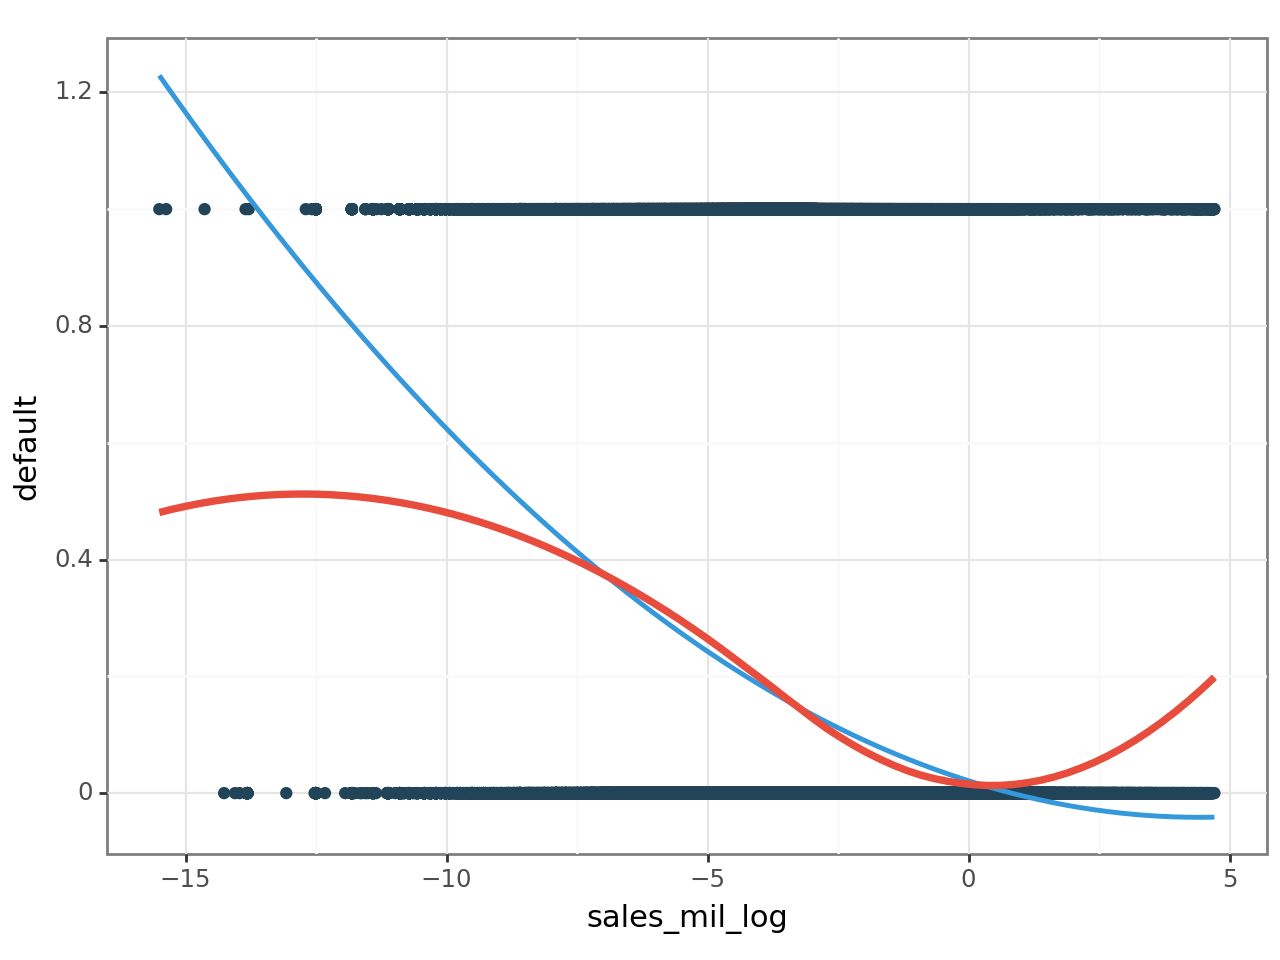

<Figure Size: (640 x 480)>

In [29]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color="#214459")
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color="#3498db", se=False)
    + geom_smooth(method="loess", color="#e74c3c", se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)

# 3. Splitting into train and holdout

## 3.1 Creating TRAIN set

In [30]:
data_train = data[data['year'] < 2014]

len(data_train)

417708

In [31]:
# Calculate missing values for each variable
missing_values = data_train.isnull().sum()

missing_values

year                        0
comp_id                     0
begin                  195279
end                    195279
COGS                   402120
                        ...  
ceo_young                   0
labor_avg_mod               0
flag_miss_labor_avg         0
default_f                   0
sales_mil_log_sq       202589
Length: 119, dtype: int64

## 3.2 Creating HOLDOUT set

In [32]:
data_holdout = data[(data['ind2'] == 26) & 
                 (data['year'] == 2014) & 
                 (data['sales'] >= 1000) & 
                 (data['sales'] <= 10000000)]

data_holdout['year'].value_counts()

print(data_holdout['default'].value_counts())

len(data_holdout)

default
0    981
1     56
Name: count, dtype: int64


1037

In [33]:
# Calculate missing values for each variable
missing_values = data_holdout.isnull().sum()

missing_values

year                     0
comp_id                  0
begin                    0
end                      0
COGS                   948
                      ... 
ceo_young                0
labor_avg_mod            0
flag_miss_labor_avg      0
default_f                0
sales_mil_log_sq         0
Length: 119, dtype: int64

In [34]:
data_holdout.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1037.0,2.014000e+03,0.000000e+00,2.014000e+03,2.014000e+03,2.014000e+03,2.014000e+03,2.014000e+03
comp_id,1037.0,1.550474e+11,1.358914e+11,6.538183e+06,3.413414e+10,1.205030e+11,2.552776e+11,4.628231e+11
COGS,89.0,2.422399e+05,4.842414e+05,0.000000e+00,0.000000e+00,1.622222e+03,2.587444e+05,2.659767e+06
amort,1035.0,2.106789e+04,9.177529e+04,0.000000e+00,4.074074e+02,1.918519e+03,8.962963e+03,1.927378e+06
curr_assets,1037.0,3.347084e+05,2.802615e+06,0.000000e+00,1.231111e+04,3.825555e+04,1.649444e+05,8.808707e+07
...,...,...,...,...,...,...,...,...
flag_miss_ceo_age,1037.0,1.099325e-01,3.129565e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
ceo_young,1037.0,1.523626e-01,3.595454e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
labor_avg_mod,1037.0,1.186136e+00,2.895822e+00,8.333334e-02,1.666667e-01,6.250000e-01,1.009435e+00,4.635417e+01
flag_miss_labor_avg,1037.0,3.008679e-01,4.588567e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


# 4. Cleaning Data

## 4.1 Dealing with missing values

In [35]:
# Calculate missing values for each variable
missing_values = data_train.isna().sum()

missing_values

year                        0
comp_id                     0
begin                  195279
end                    195279
COGS                   402120
                        ...  
ceo_young                   0
labor_avg_mod               0
flag_miss_labor_avg         0
default_f                   0
sales_mil_log_sq       202589
Length: 119, dtype: int64

In [36]:
# Calculate missing values for each variable
missing_values = data_holdout.isna().sum()

missing_values

year                     0
comp_id                  0
begin                    0
end                      0
COGS                   948
                      ... 
ceo_young                0
labor_avg_mod            0
flag_miss_labor_avg      0
default_f                0
sales_mil_log_sq         0
Length: 119, dtype: int64

In [37]:
print(list(data_holdout.columns))

['year', 'comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod', 'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales', 'personnel_exp', 'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', 'founded_year', 'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'founded_date', 'exit_date', 'status_alive', 'default', 'ln_sales', 'sales_mil', 'sales_mil_log', 'd1_sales_mil_log', 'age', 'new', 'ind2_cat', 'age2', 'foreign_management', 'gender_m', 'm_region_loc', 'flag_asset_problem', 'total_assets_bs', 'extra_exp_pl', 'extra_inc_pl', 'extra_profit_loss_pl', 'inc_bef_tax_pl', 'inventories_pl', 'material_exp_pl', 'profit_loss_year_pl', 'personnel_exp_pl', '

In [38]:
def compare_missing_values(data_train, data_holdout):
    # Calculate missing values for each variable in data_train
    missing_values_train = data_train.isnull().sum()

    # Calculate missing values for each variable in data_holdout
    missing_values_holdout = data_holdout.isnull().sum()

    # Convert Series to DataFrame for easier manipulation
    df_missing_values_train = missing_values_train.reset_index()
    df_missing_values_train.columns = ['Variable', 'MissingValuesTrain']

    df_missing_values_holdout = missing_values_holdout.reset_index()
    df_missing_values_holdout.columns = ['Variable', 'MissingValuesHoldout']

    # Merge the two dataframes on 'Variable' to compare
    comparison_df = pd.merge(df_missing_values_train, df_missing_values_holdout, on='Variable')

    # Filter to show only variables with missing values in both data_train and data_holdout
    comparison_df = comparison_df[(comparison_df['MissingValuesTrain'] > 0) & (comparison_df['MissingValuesHoldout'] > 0)]

    # Optionally, sort by 'MissingValuesHoldout' for better visualization
    comparison_df.sort_values(by='MissingValuesHoldout', ascending=False, inplace=True)

    return comparison_df

# Assuming 'data_train' and 'data_holdout' are your DataFrame subsets
# Now you can call the function with your datasets
comparison_df = compare_missing_values(data_train, data_holdout)

# Print the comparison DataFrame
print(comparison_df)

                       Variable  MissingValuesTrain  MissingValuesHoldout
27                            D              417708                  1037
32                    exit_year              380493                  1014
46                    exit_date              363573                  1012
11                finished_prod              402775                   950
26                        wages              402350                   949
4                          COGS              402120                   948
18                net_dom_sales              402120                   948
19                net_exp_sales              402120                   948
36                   birth_year              296715                   114
38                       gender              247851                    31
58                     gender_m              247851                    31
57           foreign_management              247851                    31
56                         age2       

Based on these  findings, it seems to be a good idea to remove `D`, `COGS`, `finished_prod`, `wages`,
`net_dom_sales`, and `net_exp_sales`


In [39]:
# Dropping the columns with too many missing values in the original data
data_train = data_train.drop(columns = ['D', 
                            'COGS',
                            'finished_prod', 
                            'wages', 
                            'net_dom_sales', 
                            'net_exp_sales'])

In [40]:
# Dropping the columns with too many missing values in the holdout data
data_holdout = data_holdout.drop(columns = ['D', 
                            'finished_prod',
                            'COGS'                
                            'wages', 
                            'net_dom_sales', 
                            'net_exp_sales'])

In [41]:
comparison_df = compare_missing_values(data_train, data_holdout)

# Print the comparison DataFrame
print(comparison_df)

                       Variable  MissingValuesTrain  MissingValuesHoldout
26                    exit_year              380493                  1014
40                    exit_date              363573                  1012
30                   birth_year              296715                   114
31                inoffice_days              247851                    31
47                          age              247879                    31
52                     gender_m              247851                    31
25                 founded_year              247879                    31
27                    ceo_count              247851                    31
28                      foreign              247851                    31
29                       female              247851                    31
51           foreign_management              247851                    31
32                       gender              247851                    31
33                       origin       

## 4.2 Dealing with 0 values

In [42]:
# Assuming 'data_train' and 'data_holdout' are your DataFrame variables
# For numerical variables (mean/median imputation)
for column in ['inoffice_days', 'age', 'age2', 'ceo_count', 'amort']:
    data_train[column].fillna(data_train[column].median(), inplace=True)
    data_holdout[column].fillna(data_holdout[column].median(), inplace=True)


In [43]:
# For categorical variables (mode imputation or placeholder)
for column in ['gender_m', 'gender', 'origin', 'region_m', 'm_region_loc']:
    mode_train = data_train[column].mode().iloc[0]
    mode_holdout = data_holdout[column].mode().iloc[0]
    data_train[column].fillna(mode_train, inplace=True)
    data_holdout[column].fillna(mode_holdout, inplace=True)

In [44]:
# For 'foreign' and 'foreign_management', assuming binary/flag nature
for column in ['foreign', 'foreign_management']:
    data_train[column].fillna(0, inplace=True) # Assuming 0 indicates absence
    data_holdout[column].fillna(0, inplace=True)


# 5. Define variables

In [45]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

In [46]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

In [47]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

In [48]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [49]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

# 6. Model setups

In [50]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)